In [1]:
import os 
import pandas as pd
import sys
import glob
import numpy as np 
import matplotlib.pyplot as plt 
import matplotlib 
import seaborn as sns

Beginning with methylation, let's examine the NLR mapping coverage and quality across accessions. The goal here is to determine thresholds for filtering and examine the quality of this dataset. 

In [15]:
#get all the methylation coverage files
meth_files=glob.glob('/global/scratch/users/chandlersutherland/e16/*/em/bismark/coverage/*tsv')
meth_files

['/global/scratch/users/chandlersutherland/e16/B97/em/bismark/coverage/B97_rep1_1_val_1_bismark_bt2_pe.sorted_clean_coverage.tsv',
 '/global/scratch/users/chandlersutherland/e16/B97/em/bismark/coverage/ERR5347668_1_val_1_bismark_bt2_pe.sorted_clean_coverage.tsv',
 '/global/scratch/users/chandlersutherland/e16/Oh43/em/bismark/coverage/ERR5347724_1_val_1_bismark_bt2_pe.sorted_clean_coverage.tsv',
 '/global/scratch/users/chandlersutherland/e16/Oh43/em/bismark/coverage/ERR5347725_1_val_1_bismark_bt2_pe.sorted_clean_coverage.tsv',
 '/global/scratch/users/chandlersutherland/e16/Oh43/em/bismark/coverage/ERR5347726_1_val_1_bismark_bt2_pe.sorted_clean_coverage.tsv',
 '/global/scratch/users/chandlersutherland/e16/Tx303/em/bismark/coverage/Tx303_rep1_1_val_1_bismark_bt2_pe.sorted_clean_coverage.tsv',
 '/global/scratch/users/chandlersutherland/e16/Tx303/em/bismark/coverage/ERR5347738_1_val_1_bismark_bt2_pe.sorted_clean_coverage.tsv',
 '/global/scratch/users/chandlersutherland/e16/CML69/em/bismark/

In [16]:
#load in each coverage file, and append the accession and rep information. Add to a list of dataframes, appended data 
appended_data=[]
for infile in meth_files:
    accession=infile.split('/')[6]
    rep=infile.split('/')[-1].replace('_1_val_1_bismark_bt2_pe.sorted_clean_coverage.tsv', '')

    df=pd.read_csv(infile, sep='\t', lineterminator='\n')
    df['accession'] = accession
    df['rep'] = rep
    df=df[['accession', 'rep','name', 'coverage', 'meandepth', 'meanmapq']]
    appended_data.append(df)

#concatenate the dataframes together, and filter out unnecessary columns 
all_accessions=pd.concat(appended_data)
all_accessions

for_plot=all_accessions[['accession', 'rep', 'coverage', 'meandepth', 'meanmapq']]

In [17]:
#format the data for plotting 
for_plot2=pd.melt(all_accessions, id_vars=['name', 'accession', 'rep'], value_vars=['coverage', 'meandepth', 'meanmapq'])
for_plot2

,name,accession,rep,variable,value
0,Zm00018ab016280,B97,B97_rep1,coverage,100.0000
1,Zm00018ab025360,B97,B97_rep1,coverage,98.5006
2,Zm00018ab032210,B97,B97_rep1,coverage,100.0000
3,Zm00018ab035060,B97,B97_rep1,coverage,99.2153
4,Zm00018ab039170,B97,B97_rep1,coverage,100.0000
...,...,...,...,...,...
20821,Zm00029ab438350,Ki3,ERR5347702,meanmapq,36.0000
20822,Zm00029ab442070,Ki3,ERR5347702,meanmapq,34.3000
20823,Zm00029ab460180,Ki3,ERR5347702,meanmapq,0.0000
20824,Zm00029ab462280,Ki3,ERR5347702,meanmapq,0.0000


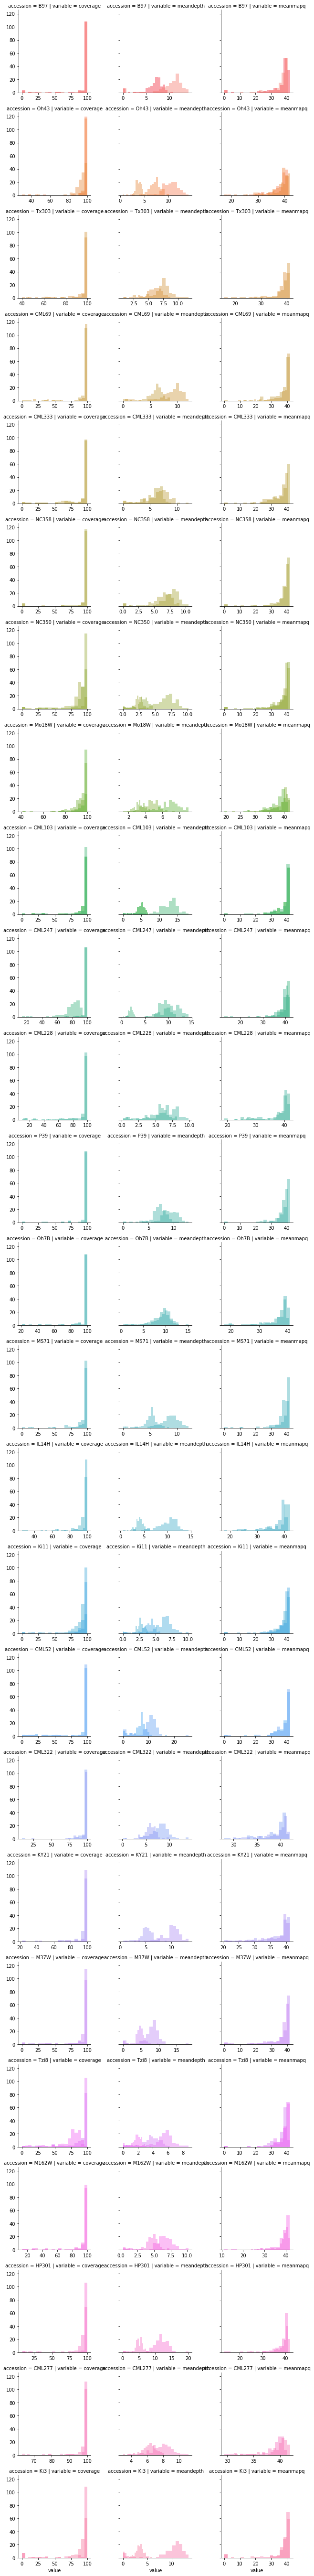

In [11]:
#general stat plotting 
g=sns.FacetGrid(for_plot2, col='variable', row='accession', hue='rep', sharex=False)
g.map(sns.distplot, 'value', bins=20, kde=False)

With our beautiful histograms in hand, let's do some more rigorous investigation of potentially problematic NLRs and accessions. 

In [28]:
#begin with the most stringent question, what are the NLRs in each accession that have no coverage? 
#More difficult question, are they shared NLRs across the NLRome  

cov=for_plot2[for_plot2['variable'] == 'coverage']
cov.describe()

len(cov['name'].unique())

3100

Looks like 75% of NLRs have >95% coverage. Nice! 

In [31]:
#in any biorep, who has no coverage? 
zero_club=cov[cov['value'] == 0]
zero_count=len(zero_club)
z=zero_club.groupby(['accession','rep']).agg({'value':['count']}).reset_index()

#who never has any coverage? 
ghosts=zero_club.groupby(['name', 'accession']).count()
ghosts[ghosts['rep'] > 1]
ghost_count=len(ghosts)

sample_size=len(cov)

print("There are "+str(zero_count)+" NLRs with no coverage in at least one biorep, and "+str(ghost_count)+" NLRs with no methylation coverage in either biorep. For a sample size of "+str(sample_size)+", not bad!")

There are 54 NLRs with no coverage in at least one biorep, and 29 NLRs with no methylation coverage in either biorep. For a sample size of 6942, not bad!


In [30]:
#now for overall now coverage (<95%) 
low_club=cov[cov['value'] <= 95]
low_count=len(low_club)
low_club.groupby(['accession','rep']).agg({'value':['count']}).reset_index().sort_values(by=('value', 'count'), ascending=False)

print("There are "+str(low_count)+" NLRs with less than 95% coverage out of "+str(sample_size)+" NLRs.")

There are 1661 NLRs with less than 95% coverage out of 6942 NLRs.


In [53]:
mean_depth=for_plot2[for_plot2['variable'] == 'meandepth']
mean_depth.describe()

,value
count,6942.000000
mean,6.529976
std,3.087805
min,0.000000
25%,4.287740
50%,6.394480
75%,8.549527
max,25.669200


In [54]:
mean_map=for_plot2[for_plot2['variable'] == 'meanmapq']
mean_map.describe()

,value
count,6942.000000
mean,37.730271
std,5.517214
min,0.000000
25%,37.300000
50%,39.600000
75%,40.600000
max,42.000000


Great! Now rinse and repeat for STAR output

In [2]:
#get all the expression coverage files
exp_files=glob.glob('/global/scratch/users/chandlersutherland/e16/*/rna_tip/STAR/coverage/*tsv')
exp_files

['/global/scratch/users/chandlersutherland/e16/B97/rna_tip/STAR/coverage/ERR3791685_Aligned.sortedByCoord.out_clean_coverage.tsv',
 '/global/scratch/users/chandlersutherland/e16/B97/rna_tip/STAR/coverage/ERR3791683_Aligned.sortedByCoord.out_clean_coverage.tsv',
 '/global/scratch/users/chandlersutherland/e16/B97/rna_tip/STAR/coverage/ERR3791684_Aligned.sortedByCoord.out_clean_coverage.tsv',
 '/global/scratch/users/chandlersutherland/e16/Oh43/rna_tip/STAR/coverage/ERR3791724_Aligned.sortedByCoord.out_clean_coverage.tsv',
 '/global/scratch/users/chandlersutherland/e16/Oh43/rna_tip/STAR/coverage/ERR3791725_Aligned.sortedByCoord.out_clean_coverage.tsv',
 '/global/scratch/users/chandlersutherland/e16/Tx303/rna_tip/STAR/coverage/ERR3791731_Aligned.sortedByCoord.out_clean_coverage.tsv',
 '/global/scratch/users/chandlersutherland/e16/Tx303/rna_tip/STAR/coverage/ERR3791732_Aligned.sortedByCoord.out_clean_coverage.tsv',
 '/global/scratch/users/chandlersutherland/e16/Tx303/rna_tip/STAR/coverage/ER

In [3]:
#load in each coverage file, and append the accession and rep information. Add to a list of dataframes, appended data 
expr_data=[]
for infile in exp_files:
    accession=infile.split('/')[6]
    rep=infile.split('/')[-1].replace('_Aligned.sortedByCoord.out_clean_coverage.tsv', '')

    df=pd.read_csv(infile, sep='\t', lineterminator='\n')
    df['accession'] = accession
    df['rep'] = rep
    df=df[['accession', 'rep','name', 'coverage', 'meandepth', 'meanmapq']]
    expr_data.append(df)

#concatenate the dataframes together, and filter out unnecessary columns 
all_accessions_expr=pd.concat(expr_data)
all_accessions_expr

for_plot_expr=all_accessions_expr[['accession', 'rep', 'coverage', 'meandepth', 'meanmapq']]

#format the data for plotting 
for_plot2_expr=pd.melt(all_accessions_expr, id_vars=['name', 'accession', 'rep'], value_vars=['coverage', 'meandepth', 'meanmapq'])
for_plot2_expr

,name,accession,rep,variable,value
0,Zm00018ab425010,B97,ERR3791685,coverage,94.4939
1,Zm00018ab425040,B97,ERR3791685,coverage,94.2951
2,Zm00018ab425630,B97,ERR3791685,coverage,66.6143
3,Zm00018ab427290,B97,ERR3791685,coverage,24.3014
4,Zm00018ab430370,B97,ERR3791685,coverage,36.3534
...,...,...,...,...,...
13552,Zm00029ab438350,Ki3,ERR3791709,meanmapq,255.0000
13553,Zm00029ab442070,Ki3,ERR3791709,meanmapq,1.8000
13554,Zm00029ab460180,Ki3,ERR3791709,meanmapq,1.0000
13555,Zm00029ab462280,Ki3,ERR3791709,meanmapq,0.0486


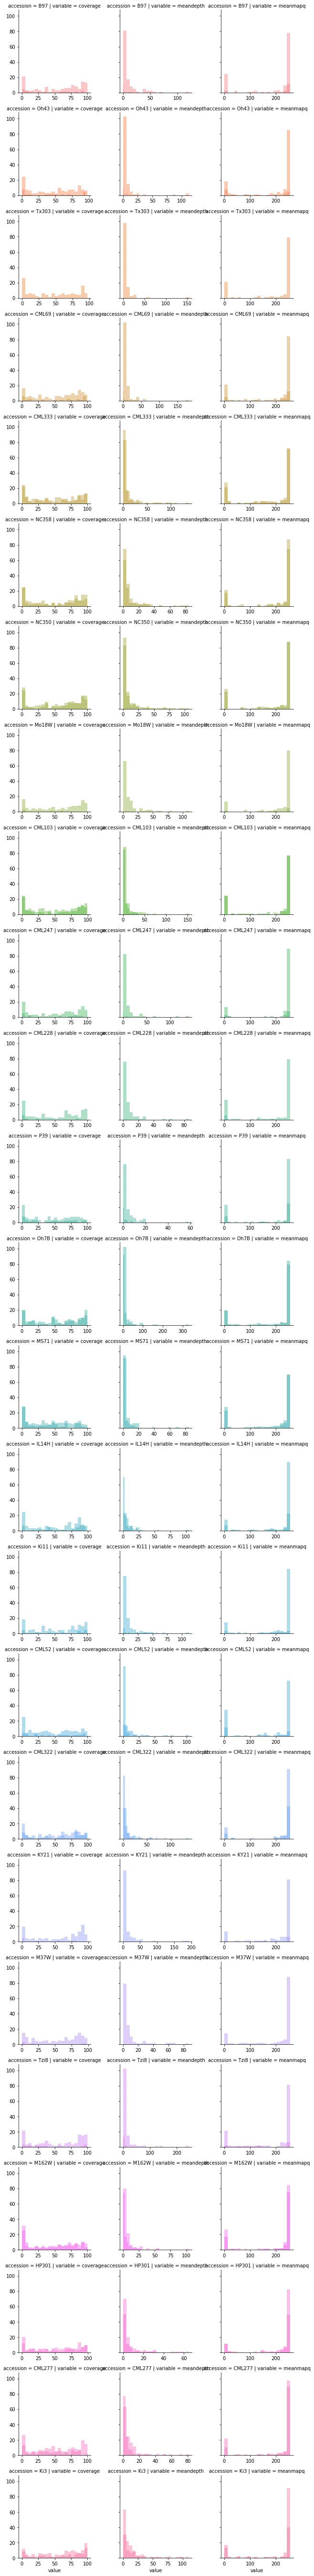

In [65]:
#general stat plotting 
g=sns.FacetGrid(for_plot2_expr, col='variable', row='accession', hue='rep', sharex=False)
g.map(sns.distplot, 'value', bins=20, kde=False)

In [26]:
cov_expr=for_plot2_expr[for_plot2_expr['variable'] == 'coverage']
cov_expr.describe()

,value
count,4519.000000
mean,50.304505
std,35.026145
min,0.000000
25%,14.114800
50%,55.313700
75%,84.091050
max,100.000000


In [23]:
len(cov_expr['name'].unique())

3100

In [32]:
#in any biorep, who has no coverage? 
zero_club_expr=cov_expr[cov_expr['value'] == 0]
zero_count_expr=len(zero_club_expr)
ze=zero_club_expr.groupby(['accession','rep']).agg({'value':['count']}).reset_index()

#who never has any coverage? 
ghosts_expr=zero_club_expr.groupby(['name', 'accession']).count()
ghosts_expr[ghosts_expr['rep'] > 1]
ghost_count_expr=len(ghosts_expr)

sample_size_expr=len(cov_expr)

print("There are "+str(zero_count_expr)+" NLRs with no coverage in at least one biorep, and "+str(ghost_count_expr)+" NLRs with no expression coverage in either biorep. For a sample size of "+str(sample_size)+", not bad!")

There are 569 NLRs with no coverage in at least one biorep, and 427 NLRs with no expression coverage in either biorep. For a sample size of 6942, not bad!


In [51]:
#Which NLRs have zero counts in both data sets?
meth_genes=zero_club.groupby(['name', 'accession']).agg({'value':['count']})
expr_genes=zero_club_expr.groupby(['name', 'accession']).agg({'value':['count']})

no_data=pd.merge(meth_genes, expr_genes, how='inner', on='name')
no_data

,value_x,value_y
,count,count
name,,
Zm00020ab447150,1,2
Zm00021ab448620,2,2
Zm00029ab367660,2,2
Zm00029ab460180,1,1
Zm00030ab409770,3,2
Zm00032ab424580,1,1
Zm00032ab424640,2,1
Zm00036ab418460,3,2
